In [7]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report
import scipy.stats
import math
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import myutils as utils

In [2]:
spell = Speller(lang='en')
nltk.download('stopwords')
nltk.download('punkt')
tk = RegexpTokenizer(r'\w+')


schemas = ["vulnerable", "angry", "impulsive", "happy", "detached", "punishing", "healthy"]
num_of_schemas = 7
max_words = 2000
max_epochs = 30
vec_size = 500

[nltk_data] Downloading package stopwords to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def gof_spear(X, Y):
    # spearman correlation of columns (schemas)
    gof_spear = np.zeros(X.shape[1])
    for schema in range(num_of_schemas):
        rho, p = spearmanr(X[:, schema], Y[:, schema])
        gof_spear[schema] = rho
    return gof_spear

# weighting model output (spearman correlations) by schema frequencies in training set and returning mean over schemas
def performance(train_y,output):
    train_y = np.array(train_y)
    train_y[train_y>0]=1
    weighting = train_y.sum(axis=0)/train_y.shape[0]
    perf = output * weighting
    return np.nanmean(np.array(perf), axis=0)

def svm_scaler(train_X):
        # scale the data
        scaler_texts = StandardScaler()
        scaler_texts = scaler_texts.fit(train_X)
        return scaler_texts

def svm_classification(train_X, train_y, text_scaler, kern):
    models = []
    train_X = text_scaler.transform(train_X)
    # fit a new support vector regression for each schema
    for schema in range(len(schemas)):
        model = svm.SVC(kernel=kern)
        # model.fit(train_X, train_y[:, schema])
        param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

        grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
        grid.fit(x_train, y_train[:, schema])
        # multilabel_classifier = multilabel_classifier.fit(x_train, y_train)
        print(grid.best_params_)
        print(grid.best_estimator_)
        models.append(model)
    return models

def svm_predict(svm_models,test_X,train_y,test_y,text_scaler, kern_name):
    #empty array to collect the results (should have shape of samples to classify)
    votes = np.zeros(test_y.shape)
    for schema in range(num_of_schemas):
        svm_model=svm_models[schema]
        prediction = svm_model.predict(text_scaler.transform(test_X))
        votes[:,schema] = prediction

    out_arr = []
    for schema in range(num_of_schemas):
        out = accuracy_score(votes[:, schema], test_y[:, schema])
        print(schemas[schema], out)
        out_arr.append(out)

    plot_data(out_arr, kern_name)

    return out
def plot_data(result, kernel_name):
    plt.xlabel('Schemas')
    plt.ylabel('Accuracy')
    plt.bar(schemas, result, color=['red', 'blue', 'purple', 'green', 'orange', 'lavender', 'yellow'])
    if kernel_name is 'rbf':
        plt.title('RBF')
    elif kernel_name is 'poly':
        plt.title('Polynomial')
    else:
        plt.title('Linear')
    plt.savefig('../plots/svm/{}'.format(kernel_name))
    plt.show()

<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-17a4b6a8c5c0>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if kernel_name is 'rbf':
<ipython-input-3-17a4b6a8c5c0>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif kernel_name is 'poly':


Accuracy:  0.41522491349480967
F1 Score:  0.49088450038461995
              precision    recall  f1-score   support

  vulnerable       0.00      0.00      0.00        95
       angry       0.80      0.04      0.07       109
   impulsive       0.00      0.00      0.00        62
       happy       0.73      1.00      0.84       210
    detached       0.00      0.00      0.00        96
   punishing       0.50      0.02      0.03        62
     healthy       0.92      1.00      0.96       267

   micro avg       0.82      0.53      0.65       901
   macro avg       0.42      0.29      0.27       901
weighted avg       0.57      0.53      0.49       901
 samples avg       0.82      0.65      0.70       901

C:\Users\Irene Park\anaconda3\envs\ResearchProject\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

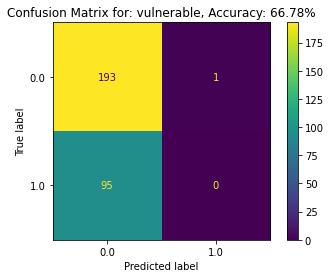

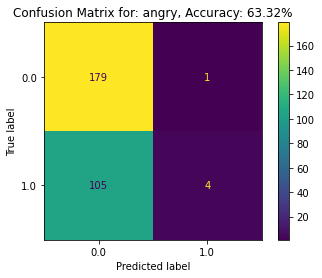

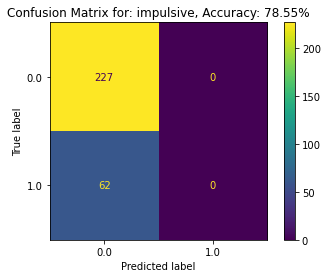

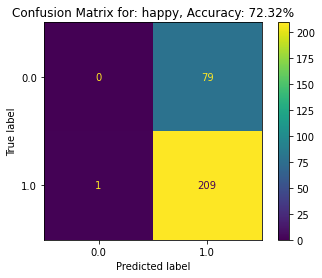

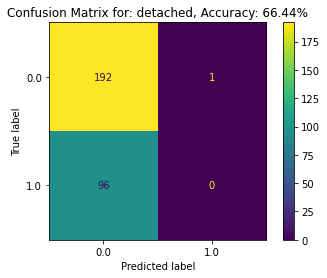

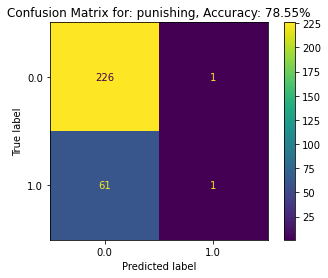

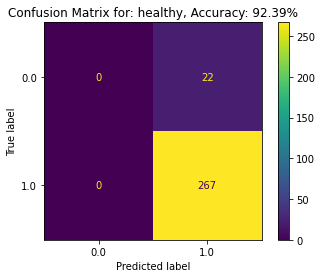

In [14]:
def svm_diff_approach_without_grid():
    randomSeed = 42
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = utils.get_text_labels(df)
    processed, tokenized = utils.pre_process_data(texts)
    fastText_model = utils.training_model_fast_text()

    vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            vectors.append(row_vec)
        else:
            # print("why length = 0", row_vec, words)
            vectors.append(row_vec)

    X = vectors
    np_x = np.asarray(X)
    np_y = np.asarray(labels)

    x_train, y_train, x_test, y_test, test_percent = utils.split_data(np_x, np_y, 0.2)
    # scaled_train = svm_scaler(x_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    # x_train = scaled_train.transform(x_train)
    # x_test = scaled_train.transform(x_test)

    
    svm_model = OneVsRestClassifier(svm.SVC(random_state=randomSeed, C=1000, gamma=1, kernel='rbf'))
    # clf = CalibratedClassifierCV(svm_model)

    # Make it an Multilabel classifier
    multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)

    # Fit the data to the Multilabel classifier
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    # Get predictions for test data
    schema_test_pred = multilabel_classifier.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    print(classification_report(y_test, schema_test_pred, target_names=schemas))

    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])))
        plt.show()
        i += 1
svm_diff_approach_without_grid()

In [5]:
def svm_diff_approach_with_grid():
    randomSeed = 42
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = utils.get_text_labels(df)
    processed, tokenized = utils.pre_process_data(texts)
    fastText_model = utils.training_model_fast_text()

    vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            vectors.append(row_vec)
        else:
            # print("why length = 0", row_vec, words)
            vectors.append(row_vec)

    X = vectors
    np_x = np.asarray(X)
    np_y = np.asarray(labels)

    x_train, y_train, x_test, y_test, test_percent = utils.split_data(np_x, np_y, 0.2)
    # scaled_train = svm_scaler(x_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    # x_train = scaled_train.transform(x_train)
    # x_test = scaled_train.transform(x_test)

    
    svm_model = svm.SVC(random_state=randomSeed, kernel='rbf')
    # clf = CalibratedClassifierCV(svm_model)

    # Make it an Multilabel classifier
    multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)

    # Fit the data to the Multilabel classifier

    param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

    grid = GridSearchCV(multilabel_classifier, param_grid, refit = True, verbose = 3)
    grid.fit(x_train, y_train)
    # multilabel_classifier = multilabel_classifier.fit(x_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)

    # Get predictions for test data
    # schema_test_pred = multilabel_classifier.predict(x_test)
    # print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    # print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    # print(classification_report(y_test, schema_test_pred, target_names=schemas))

    # # Generate multiclass confusion matrices
    # matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # # Plotting matrices: code
    # i = 1
    # for mat in matrices:
    #     cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
    #     plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])))
    #     plt.show()
    #     i += 1

svm_diff_approach_with_grid()

Fitting 5 folds for each of 25 candidates, totalling 125 fits


ValueError: Invalid parameter C for estimator MultiOutputClassifier(estimator=SVC(random_state=42), n_jobs=-1). Check the list of available parameters with `estimator.get_params().keys()`.

In [32]:
def svm_fast_text():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = utils.get_text_labels(df)
    processed, tokenized = utils.pre_process_data(texts)
    fastText_model = utils.training_model_fast_text()

    vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            vectors.append(row_vec)
        else:
            # print("why length = 0", row_vec, words)
            vectors.append(row_vec)

    X = vectors
    np_x = np.asarray(X)
    np_y = np.asarray(labels)

    x_train, y_train, x_test, y_test, test_percent = utils.split_data(np_x, np_y, 0.2)
    scaled_train = svm_scaler(x_train)

    # svm
    svm_rbf_models = svm_classification(x_train, y_train, scaled_train, 'rbf')
    print("RBF")
    svm_rbf_out = svm_predict(svm_rbf_models, x_test, y_train, y_test, scaled_train, 'rbf')
    svm_lin_models = svm_classification(x_train, y_train, scaled_train, 'linear')
    print("Linear")
    svm_lin_out = svm_predict(svm_lin_models, x_test, y_train, y_test, scaled_train, 'linear')
    svm_poly_models = svm_classification(x_train, y_train, scaled_train, 'poly')
    print("Poly")
    svm_poly_out = svm_predict(svm_poly_models, x_test, y_train, y_test, scaled_train, 'poly')

svm_fast_text()

MemoryError: bad allocation

In [26]:
def svm_with_grid():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = utils.get_text_labels(df)
    processed, tokenized = utils.pre_process_data(texts)
    fastText_model = utils.training_model_fast_text()

    vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            vectors.append(row_vec)
        else:
            # print("why length = 0", row_vec, words)
            vectors.append(row_vec)

    X = vectors
    np_x = np.asarray(X)
    np_y = np.asarray(labels)

    x_train, y_train, x_test, y_test, test_percent = utils.split_data(np_x, np_y, 0.2)
    scaled_train = svm_scaler(x_train)

    model_to_set = svm.SVC(kernel="rbf", C=4650, gamma=3.95)
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    # Cross Validation Part
    # param_grid = {'estimator__C': [4550, 4570, 4600, 4630, 4650],
    #               'estimator__gamma': [5, 4.3, 4, 3.95, 3.9]}

    # model_tunning = GridSearchCV(multilabel_classifier, param_grid=param_grid, scoring='f1_weighted', refit = True, verbose = 3)

    # model_tunning.fit(x_train, y_train)
    # print(model_tunning.best_score_, model_tunning.best_params_)

    schema_test_pred = multilabel_classifier.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    print(classification_report(y_test, schema_test_pred, target_names=schemas))

    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])))
        plt.show()
        i += 1

print(svm_with_grid())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........estimator__C=4550, estimator__gamma=5; total time=   1.1s
[CV 2/5] END ..........estimator__C=4550, estimator__gamma=5; total time=   1.1s
[CV 3/5] END ..........estimator__C=4550, estimator__gamma=5; total time=   1.1s
[CV 4/5] END ..........estimator__C=4550, estimator__gamma=5; total time=   1.0s
[CV 5/5] END ..........estimator__C=4550, estimator__gamma=5; total time=   1.1s
[CV 1/5] END ........estimator__C=4550, estimator__gamma=4.3; total time=   1.1s
[CV 2/5] END ........estimator__C=4550, estimator__gamma=4.3; total time=   1.2s
[CV 3/5] END ........estimator__C=4550, estimator__gamma=4.3; total time=   1.2s
[CV 4/5] END ........estimator__C=4550, estimator__gamma=4.3; total time=   1.1s
[CV 5/5] END ........estimator__C=4550, estimator__gamma=4.3; total time=   1.3s
[CV 1/5] END ..........estimator__C=4550, estimator__gamma=4; total time=   1.2s
[CV 2/5] END ..........estimator__C=4550, estim